In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from OIP21_lib_ImageProcessing_V6 import *
#%matplotlib notebook

In [9]:
def skeletonize(img):
    """ OpenCV function to return a skeletonized version of img, a Mat object"""

    #  hat tip to http://felix.abecassis.me/2011/09/opencv-morphological-skeleton/

    img = img.copy() # don't clobber original
    skel = img.copy()

    skel[:,:] = 0
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    while True:
        eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
        temp  = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img[:,:] = eroded[:,:]
        if cv2.countNonZero(img) == 0:
            break

    return skel

In [2]:
def FloodFillLabeling_modified(imgBIN):

    label = 2
    # collect the non-zero / foreground elements: 
    nzi = np.nonzero(imgBIN)
    # make copy: 
    IMG = deepcopy(imgBIN)

    zones = []
    # Flood fill loop: 
    #for cnt, u in enumerate(FGu):
    for i in np.transpose(nzi):
        IMG , zone = FloodFill_BF_modified(IMG, i[0] , i[1], label)
        if (not zone[0]==0) and (not zone[1]==IMG.shape[0]) and (not zone[2]==0) and (not zone[3]==IMG.shape[1]):
            zones.append(zone)
            label = label + 1
    return IMG ,zones

#insert image, (u,v) (start pixel), label nr
def FloodFill_BF_modified(IMG, u, v, label):
    '''
    Breadth-First Version (we treat lists as queues)
    '''
    xmax=0
    xmin=IMG.shape[0]
    ymax=0
    ymin=IMG.shape[1]
    S = []
    S.append([u,v])
    while S:  # While S is not empty...
        xy = S[0]
        x = xy[0]
        y = xy[1]
        S.pop(0)
        if x <= IMG.shape[0] and y <= IMG.shape[1] and  IMG[x,y] == 1:
            if xmax<x:
                xmax=x
            elif xmin>x:
                xmin=x
            if ymax<y:
                ymax=y
            elif ymin>y:
                ymin=y
            IMG[x,y] = label
            if x+1<IMG.shape[0]:
                S.append([x+1, y])
            if y+1<IMG.shape[1]:
                S.append([x, y+1])
            if y-1>=0:
                S.append([x,y-1])
            if x-1>=0:
                S.append([x-1,y])
    return IMG , [xmax,xmin,ymax,ymin]


Text(0.5, 1.0, 'Region label OIP')

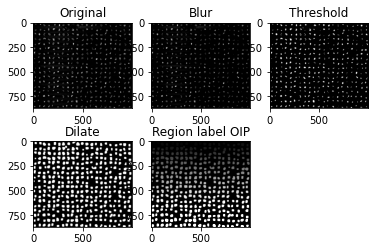

In [3]:
Number = 2
# Start loading in the 3 image types, 
# The first type is a Circle cluster image
# The second type is a Line/Rod cluster image
# The third type is a triangle cluster image
if Number == 1:
    img = cv2.imread('001_002.tif', cv2.IMREAD_GRAYSCALE)
elif Number == 2:
    img = cv2.imread('R001_001.tif', cv2.IMREAD_GRAYSCALE)
elif Number == 3:
    img = cv2.imread('T001.png', cv2.IMREAD_GRAYSCALE)

# Then we cut the gunk that is not needed from the image, this would be un-needed data
# or things that should not be in the image like half-clusters and other things that would
# screw with the data.

if Number == 1:
    img = img[0:870,:]
    img_org = img
elif Number == 2: 
    img = img[0:870,0:1000]
    #img = img[52:244,382:664]
    #img = img[0:870,0:679]
    #img = img[100:870,0:750]
    img_org = img
elif Number == 3:
    img[755:844,672:845] = 0
    img_org = img

#prepare for region labeling    
img = cv2.medianBlur(img, 7)
ret,thresh = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
kernel = np.ones((7,7), np.uint8)
threshDil = cv2.dilate(thresh, kernel, iterations=2)

#255 to 1 since floodfill is expecting that
threshDilBin = threshDil.copy()
threshDilBin[threshDilBin == 255] = 1
threshDilBin = threshDilBin.astype('uint16')

labelsOIP , zones = FloodFillLabeling_modified(threshDilBin)

plt.subplot(2,3,1)
plt.imshow(img_org,'gray',vmin=0,vmax=255)
plt.title("Original")
plt.subplot(2,3,2)
plt.imshow(img,'gray',vmin=0,vmax=255)
plt.title("Blur")
plt.subplot(2,3,3)
plt.imshow(thresh,'gray',vmin=0,vmax=255)
plt.title("Threshold")
plt.subplot(2,3,4)
plt.imshow(threshDil,'gray',vmin=0,vmax=255)
plt.title("Dilate")
plt.subplot(2,3,5)
plt.imshow(labelsOIP,'gray',vmin=0,vmax=255)
plt.title("Region label OIP")

In [4]:
height, width = np.shape(img_org)
clusterArray=[]

for i in zones:
    y2=i[0]
    y1=i[1]
    x2=i[2]
    x1=i[3]
    if(x1>0 and y1>0 and x2<width-1 and y2<height-1):
        clusterArray.append(img_org[y1:y2,x1:x2])


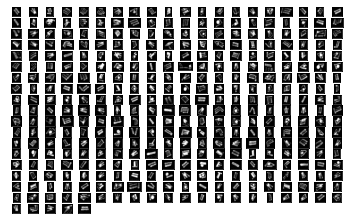

In [5]:
size = math.ceil(math.sqrt(len(clusterArray)))
count = 1

for i in clusterArray:
    plt.subplot(size,size,count)
    plt.imshow(i,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    count+=1

([], [])

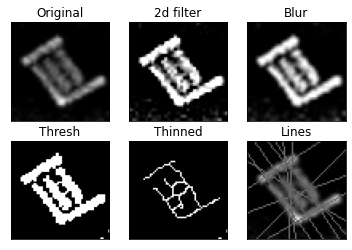

In [351]:
img = clusterArray[8].copy()
scale_percent = 200 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

img = cv2.resize(img, dim) 
kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
img1 = cv2.filter2D(img, -1, kernel)
img2 = cv2.blur(img1, (3,3))
ret,thresh = cv2.threshold(img1,100,255,cv2.THRESH_BINARY)
thinned = cv2.ximgproc.thinning(thresh)

lines = cv2.HoughLines(thinned,1,np.pi/180,12)
#print(len(lines))
#print(lines)
temp = img.copy()

rotThresh = math.radians(40)
distThresh = 5

if lines is not None:
    drawLines = []
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        good = True
        for i in drawLines:
            #add if its straight up 0-3,14 fix
            
            if theta > i[1]-rotThresh and theta < i[1]+rotThresh:
                if rho > i[0]-distThresh and rho < i[0]+distThresh:
                    good = False
        
        if good:
            #print(str(rho)+"  "+ str(theta))
            drawLines.append([rho,theta])
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(temp, pt1, pt2, (100,0,0), 1)

plt.subplot(2,3,1)
plt.imshow(img,'gray',vmin=0,vmax=255)
plt.title("Original")
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(img1,'gray',vmin=0,vmax=255)
plt.title("2d filter")
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(img2,'gray',vmin=0,vmax=255)
plt.title("Blur")
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,4)
plt.imshow(thresh,'gray',vmin=0,vmax=255)
plt.title("Thresh")
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,5)
plt.imshow(thinned,'gray',vmin=0,vmax=255)
plt.title("Thinned")
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,6)
plt.imshow(temp,'gray',vmin=0,vmax=255)
plt.title("Lines")
plt.xticks([])
plt.yticks([])
